# Exercise 6 - Decision Trees

In this exercise we will implement a decision tree classifier and evaluate its performance.

In the event of a persistent problem, do not hesitate to contact the course instructor under

- paul.kahlmeyer@uni-jena.de

### Submission
- Deadline of submission:
        24.05.23 23:59
- Submission on [moodle page](https://moodle.uni-jena.de/course/view.php?id=43681)


### Help
In case you cannot solve a task, you can use the saved values within the `help` directory:
- Load arrays with [Numpy](https://numpy.org/doc/stable/reference/generated/numpy.load.html)
```
np.load('help/array_name.npy')
```
- Load functions with [Dill](https://dill.readthedocs.io/en/latest/dill.html)
```
import dill
with open('help/some_func.pkl', 'rb') as f:
    func = dill.load(f)
```

to continue working on the other tasks.

# Dataset

Here we will use a synthetic dataset for binary classification created with scikit learn (see [here](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html)).

### Task 1

Load and display the data located in `X.npy` and `y.npy`.

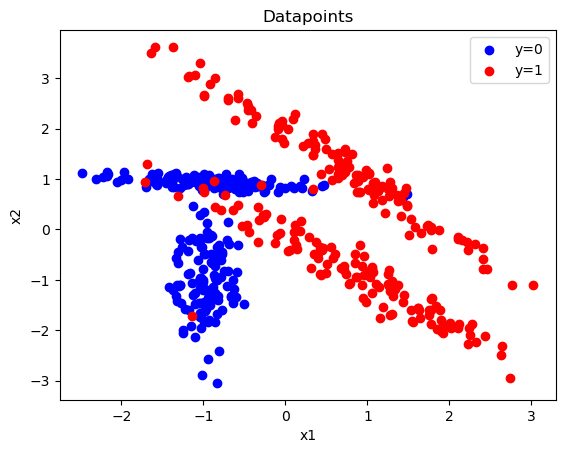

In [172]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data from the files
X = np.load('X.npy')
y = np.load('y.npy')

# Extract x1 and x2 values
x1 = X[:, 0]
x2 = X[:, 1]

# Plot x1 vs x2 with different colors for different labels
plt.scatter(x1[y == 0], x2[y == 0], c='blue', label='y=0')
plt.scatter(x1[y == 1], x2[y == 1], c='red', label='y=1')

# Set plot labels and title
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Datapoints')

# Add legend
plt.legend()

# Display the plot
plt.show()
 

# Decision Trees

Decision trees are data structures, where at each level we make a decision about a feature and at the lowest level we have a decision for a class. For example, consider the following decision tree:
<div>
<img src="images/decision_tree.png" width="800"/>
</div>
You can think of a datapoint trickling down starting at the root and ending up in one of the leaf nodes that assign a class label.

That is, learning a decision tree involves learning which question to ask at which node.

## Learning

Usually we want to select questions in a way that "unmix" the labels of a dataset the best.

As an example, consider a dataset like this:

`X = [1, 2, 3, 4]`, `y = [0, 0, 1, 1]`

Here, we could ask the question: "$X\leq 1$?", which would split the dataset into 

`X1 = [1]`, `y1 = [0]` and 

`X2 = [2, 3, 4]`, `y2 = [0, 1, 1]`.

looking at the labels of the resulting datasets `y1` and `y2`, we can see that `y1` is nicely unmixed (contains only labels of one class). However `y2` is not unmixed.

A better question would be to ask: "$X\leq 2$?", in which case we would get

`X1 = [1, 2]`, `y1 = [0, 0]` and 

`X2 = [3, 4]`, `y2 = [1, 1]`.

Here both `y1` and `y2` are perfectly unmixed.

There are many ways to quantify the "unmixing" property of a dataset. For decision trees however a popular choice is the [**Gini-Impurity**](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity). It measures the probability that we would missclasify a sample if we classified according to the distribution of labels.

Let $p_i$ be the relative frequency of class $i$ in the dataset with labels $y$, then the Gini-Impurity is defined as

\begin{align*}
I_G(y) = 1 - \sum_i p_i^2\,.
\end{align*}

In the following figure we can see the Gini-Impurity for binary classification problems depending on the relative frequency $p_0$ of class 0: 
<div>
<img src="images/gini.png" width="500"/>
</div>
If we have a perfectly unmixed dataset, the Gini-Impurity is 0. The maximum value is 0.5 if we have the same amount of both labels. Recall that for decision trees we want to split a dataset into subsets of low Gini-Impurity.

### Task 2

Implement the following function and calculate the Gini-Impurity for the labels of the dataset.

In [173]:
def gini_imp(y : np.ndarray) -> float:
    '''
    Calculates Gini-Impurity for binary labels.
    
    @Params:
        y... labels in {0, 1}
        
    @Returns: 
        Gini-Impurity
    '''
    
    # Count the occurrences of each label
    counts = np.bincount(y)
    
    # Calculate the probability of each label
    probabilities = counts / len(y)
    
    # Calculate the Gini impurity
    gini = 1 - np.sum(probabilities ** 2)
    
    return gini


# Calculate the Gini impurity for the labels
gini_impurity = gini_imp(y)

print("Gini impurity:", gini_impurity)
 

Gini impurity: 0.49992800000000004


We want to use the Gini-Impurity to evaluate how good a splitting of a dataset is. For this we simply calculate a weighted sum of the impurities of the individual splits. Let $y_0, y_1$ be splits of a dataset $y$. Then we simply compute the score

\begin{align*}
S(y_0, y_1) = \cfrac{|y_0|}{|y_0| + |y_1|}I_G(y_0) + \cfrac{|y_1|}{|y_0| + |y_1|}I_G(y_1)\,.
\end{align*}

That is we weight each the individual impurities with the size of the splits.

### Task 3

Implement the following function and calculate the score if we would split the dataset according to the question "$x_0 \leq 0$?".

In [174]:
def gini_imp_split(y0 : np.ndarray, y1 : np.ndarray) -> float:
    '''
    Weighted Gini-Impurity for a split into two sets of labels (binary classification).
    
    @Params:
        y0... label set
        y1... label set
    
    @Returns:
        Impurity score (lower = better)
    '''
    
    # Calculate the total number of samples in both sets
    total_samples = len(y0) + len(y1)
    
    # Calculate the weights for each set
    weight0 = len(y0) / total_samples
    weight1 = len(y1) / total_samples
    
    # Calculate the Gini impurity for each set
    gini0 = gini_imp(y0)
    gini1 = gini_imp(y1)
    
    # Calculate the weighted Gini impurity score
    return weight0 * gini0 + weight1 * gini1


# Split the dataset according to the condition x0 <= 0
y0 = y[X[:, 0] <= 0]
y1 = y[X[:, 0] > 0]

# Calculate the Gini impurity score for the split
score = gini_imp_split(y0, y1)

print("Gini impurity score for split x0 <= 0:", score)
 

Gini impurity score for split x0 <= 0: 0.21925534616082165


Now the challenge is to find the index and the value that produces the lowest score ($\rightarrow$ best split).
For decision trees we do this in three steps:

1. Iterate trough all $x\in X$ and all dimensions $i$. Let $x_i = v$ be the value that we observe.
2. Score the split according to "$x_i \leq v$?".
3. Report dimension $i$ and value $v$ of best score

In practice we do not use the value $v$ but rather the average of $v$ and the first value for $x_i$ that is $> v$. 

As an example, if we identified $x_0 \leq 1.5$ as the best split, we will look for the lowest value of $x_0$ that is $>1.5$ and report the mean of those two values. Lets say this next greater value is $1.6$, then we will report index 0 and value $0.5(1.5 + 1.6) = 1.55$. This way we draw the decision boundary between the datapoints rather than on the datapoints.

### Task 4

Implement the following function that searches for the best split of a dataset.

Use this function to identify the best split of our dataset.

In [175]:
def best_split(X : np.ndarray, y : np.ndarray) -> tuple:
    '''
    Identifies the best split of a dataset according to Gini-Impurity.
    
    @Params:
        X... samples
        y... labels
        
    @Returns:
        triple (index, value, Gini-Score) of split
    '''
    best_score = float('inf') 
    best_index = None 
    best_value = None  

    # Iterate through all dimensions
    for i in range(X.shape[1]):
        # Iterate through all unique values in dimension i
        for value in np.unique(X[:, i]):
            # Split the dataset based on the condition X[:, i] <= value
            y0 = y[X[:, i] <= value]
            y1 = y[X[:, i] > value]

            # Calculate the Gini impurity score for the split
            score = gini_imp_split(y0, y1)

            # Check if the current score is better than the best score found so far
            if score < best_score:
                best_score = score
                best_index = i
                best_value = value

    return best_index, best_value, best_score
    pass

# find best split for dataset
best_index, best_value, best_score = best_split(X, y)

print("Best split: Index =", best_index, ", Value =", best_value, ", Gini score =", best_score)


Best split: Index = 0 , Value = -0.17473169364175 , Gini score = 0.19709883984704135


With this functionality we have everything to recursively build up a decision tree.

Each node in the tree has the following attributes:

- `X`, `y`, `gi`: part of the dataset that is passed to the node
- `depth`, `max_depth`: depth of the node in the tree as well as the maximum depth of the tree

And can perform the following operations:

- `split`: if not already pure or at `max_depth`, finds the best split of its dataset and creates two child nodes (+1 depth)
- `predict` : given a dataset predicts labels accoding to its children (or according to its labels if we have no children)

### Task 5

Implement the following `Node` class which implements the functionality of a single node. 

Use the provided `DecisionTree` class to learn and print a decision tree on our dataset.

In [186]:
class Node():
        
    def __init__(self, X : np.ndarray, y : np.ndarray, depth : int, max_depth : int):
        '''
        Constructor for a node.
        
        @Params:
            X... samples
            y... labels
            depth... depth of this node in the tree
            max_depth... maximum depth of any node in the tree
        '''
        self.X = X
        self.y = y
        self.depth = depth
        self.max_depth = max_depth
        self.gi = gini_imp(y)
        self.left = None
        self.right = None
        self.split_index = None
        self.split_value = None
        
        
        
    def split(self):
        '''
        Creates child nodes if labels are not already pure.
        '''
        
        # Check if the node is pure (all labels are the same)
        if len(np.unique(self.y)) == 1:
            return
        
        # Check if the maximum depth of the tree has been reached
        if self.depth >= self.max_depth:
            return
        
        # Find the best split for the current node's dataset
        best_index, best_value, best_score = best_split(self.X, self.y)
        
        # Check if the best split improves the Gini impurity
        if best_score >= self.gi:
            return
        
        # Split the dataset based on the best split
        X_left = self.X[self.X[:, best_index] <= best_value]
        y_left = self.y[self.X[:, best_index] <= best_value]
        
        X_right = self.X[self.X[:, best_index] > best_value]
        y_right = self.y[self.X[:, best_index] > best_value]
        
        self.left = Node(X_left, y_left, self.depth + 1, self.max_depth)
        self.right = Node(X_right, y_right, self.depth + 1, self.max_depth)
        self.split_index = best_index
        self.split_value = best_value
        
        # Recursively split child nodes
        self.left.split()
        self.right.split()

           
        
    def predict(self, X : np.ndarray) -> np.ndarray:
        '''
        Predicts labels for samples.
        
        @Params:
            X... samples
            
        @Returns:
            predicted labels by this node
        '''
        if self.left is None and self.right is None:
            return np.full(X.shape[0], np.argmax(np.bincount(self.y)))
        
        y_pred = np.zeros(X.shape[0])
        
        indices_left = X[:, self.split_index] <= self.split_value
        indices_right = X[:, self.split_index] > self.split_value
        
        if self.left is not None:
            y_pred[indices_left] = self.left.predict(X[indices_left])
        
        if self.right is not None:
            y_pred[indices_right] = self.right.predict(X[indices_right])
        
        return y_pred
            
        
    def __repr__(self, indent="") -> str:
        '''
        String representation of the node.
        
        @Returns:
            a string that represents the subtree with this node as root.
            Something like 
            x0 < 1.5?
                str(child1)
            else
                str(child2)
            
        '''
        if self.left is None and self.right is None:
            return f"{indent}{np.bincount(self.y)[0] / np.bincount(self.y).sum()}"

        condition = f"{indent}x_{self.split_index} <= {self.split_value}?"

        child1_str = self.left.__repr__(indent + "    ") if self.left is not None else ""
        child2_str = self.right.__repr__(indent + "    ") if self.right is not None else ""

        return f"{condition}\n{child1_str}\n{indent}else:\n{child2_str}"


class DecisionTree():
    '''
    Provided. A wrapper class for the root of the decision tree.
    This will give you an idea of how the Node class is used.
    '''
    
    def __init__(self, max_depth : int = np.inf):
        '''
        Constructor of decision tree.
        
        @Params:
            max_depth... maximum depth of any node in the tree
        '''
        self.root = None
        self.max_depth = max_depth
        
    def fit(self, X : np.ndarray, y : np.ndarray):
        '''
        Learns the nodes of the decision tree.
        
        @Params:
            X... samples
            y... labels
        '''
        self.root = Node(X, y, 0, self.max_depth)
        self.root.split()
        
    def predict(self, X : np.ndarray) -> np.ndarray:
        '''
        Predicts labels for samples.
        
        @Params:
            X... samples
        '''
        return self.root.predict(X)
    
    def __repr__(self) -> str:
        '''
        String representation of the tree.
        '''
        return str(self.root)
    
# learn + print decision tree
tree = DecisionTree(max_depth=3)
tree.fit(X, y)
print(tree)
 

x_0 <= -0.17473169364175?
    x_1 <= 1.1431531066778364?
        x_0 <= -0.3428501436767867?
            0.9416666666666667
        else:
            0.5333333333333333
    else:
        0.0
else:
    x_0 <= 0.3290071772758012?
        x_1 <= 0.20223084263289937?
            0.0
        else:
            0.4090909090909091
    else:
        x_1 <= 0.5912373943820493?
            0.0
        else:
            0.0625


### Task 6

Calculate the accuracy of the decision tree on the dataset and visualize the decision boundary.

You can use `utils.plot_dec_boundary` for the visualization.

Accuracy: 0.932


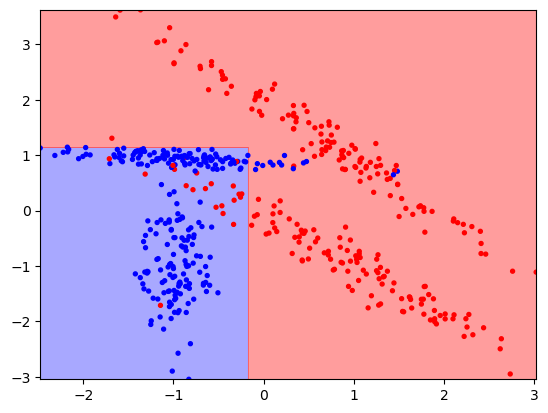

In [187]:
import utils

# Convert input data to NumPy array
X = np.array(X)

# Calculate accuracy
y_pred = tree.predict(X)
accuracy = np.mean(y_pred == y)
print("Accuracy:", accuracy)

# Visualize decision boundary
utils.plot_dec_boundary(X, y, tree)

### Task 7

Use the [scikit learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) to learn a decision tree with the same maximum depth as your tree from Task 5.

Compare the decision boundary, accuracy and the internal parameters to those of your own implementation.

In [178]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

sklearn_tree = DecisionTreeClassifier(max_depth=3)
sklearn_tree.fit(X, y)

DecisionTreeClassifier(max_depth=3)

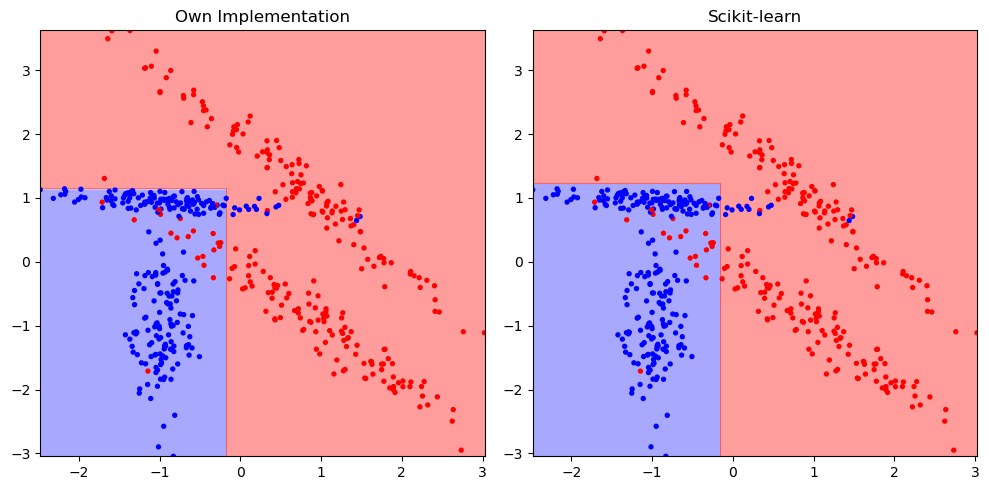

In [179]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Visualize decision boundary for your own implementation
axes[0].set_title("Own Implementation")
utils.plot_dec_boundary(X, y, tree, ax=axes[0])

# Visualize decision boundary for the scikit-learn implementation
axes[1].set_title("Scikit-learn")
utils.plot_dec_boundary(X, y, sklearn_tree, ax=axes[1])

# Display the plot
plt.tight_layout()
plt.show()

In [180]:
# Predict labels using your own implementation
y_pred_own = tree.predict(X)
accuracy_own = accuracy_score(y, y_pred_own)
print("Own Implementation Accuracy:", accuracy_own)

# Predict labels using the scikit-learn implementation
y_pred_sklearn = sklearn_tree.predict(X)
accuracy_sklearn = accuracy_score(y, y_pred_sklearn)
print("Scikit-learn Accuracy:", accuracy_sklearn)

Own Implementation Accuracy: 0.932
Scikit-learn Accuracy: 0.932


In [192]:
# Get the textual representation of the decision rules
decision_rules = export_text(sklearn_tree, feature_names=["x_0", "x_1"])

# Print the decision rules
print(tree)
print(decision_rules)


x_0 <= -0.17473169364175?
    x_1 <= 1.1431531066778364?
        x_0 <= -0.3428501436767867?
            0.9416666666666667
        else:
            0.5333333333333333
    else:
        0.0
else:
    x_0 <= 0.3290071772758012?
        x_1 <= 0.20223084263289937?
            0.0
        else:
            0.4090909090909091
    else:
        x_1 <= 0.5912373943820493?
            0.0
        else:
            0.0625
|--- x_0 <= -0.15
|   |--- x_1 <= 1.22
|   |   |--- x_0 <= -0.34
|   |   |   |--- class: 0
|   |   |--- x_0 >  -0.34
|   |   |   |--- class: 0
|   |--- x_1 >  1.22
|   |   |--- class: 1
|--- x_0 >  -0.15
|   |--- x_0 <= 0.33
|   |   |--- x_1 <= 0.47
|   |   |   |--- class: 1
|   |   |--- x_1 >  0.47
|   |   |   |--- class: 1
|   |--- x_0 >  0.33
|   |   |--- x_1 <= 0.62
|   |   |   |--- class: 1
|   |   |--- x_1 >  0.62
|   |   |   |--- class: 1



## Influence of Tree depth

Now we want to investigate the influence of the maximum tree depth on the classification accuracy.

### Task 8

Split the dataset into train- and testdata and plot the train- and test accuracy for an increasing maximum tree depth.

You can use the scikit learn implementation or your own.

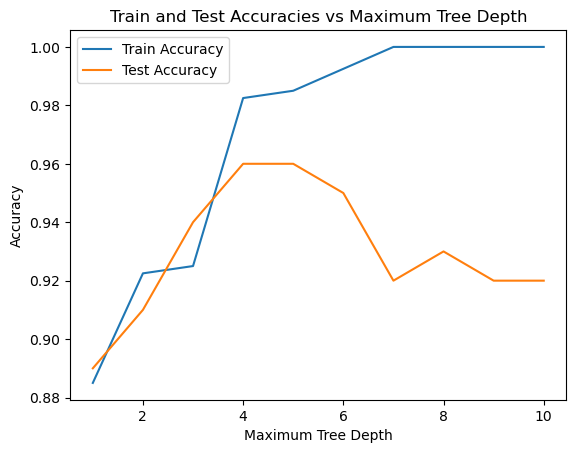

In [182]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Split the dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize lists to store train and test accuracies
train_accuracies = []
test_accuracies = []

# Set the maximum tree depth range
max_depths = range(1, 11)

# Iterate over the maximum tree depth range
for depth in max_depths:
    # Initialize the decision tree classifier
    tree = DecisionTreeClassifier(max_depth=depth)
    
    # Fit the decision tree classifier on the training data
    tree.fit(X_train, y_train)
    
    # Predict the labels for train and test data
    train_pred = tree.predict(X_train)
    test_pred = tree.predict(X_test)
    
    # Calculate the accuracies for train and test data
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)
    
    # Append the accuracies to the respective lists
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Plot the train and test accuracies
plt.plot(max_depths, train_accuracies, label='Train Accuracy')
plt.plot(max_depths, test_accuracies, label='Test Accuracy')
plt.xlabel('Maximum Tree Depth')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracies vs Maximum Tree Depth')
plt.legend()
plt.show()


### Task 9

In your own words, describe the influence of the maximum tree depth.

<font color='red'>TODO:</font> write

In [183]:
print("For a maximum depth >5, we observe overfitting. The model becomes too specific, and the predictions getting worse.\nFor a maximum depth <4, we observe underfitting. The model is too general, resulting in suboptimal predictions.\nTherefore, increasing the tree depth leads to a higher level of model specification. However, it is important to exercise caution and not get too specific to avoid overfitting.")


For a maximum depth >5, we observe overfitting. The model becomes too specific, and the predictions getting worse.
For a maximum depth <4, we observe underfitting. The model is too general, resulting in suboptimal predictions.
Therefore, increasing the tree depth leads to a higher level of model specification. However, it is important to exercise caution and not get too specific to avoid overfitting.
